In [1]:
import os, sys
import time

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from importlib import reload

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=1)

In [5]:
import utils
import dataset
# import transforms
import metric
import engine
import models.faster_rcnn
import models.ssd

In [167]:
reload(utils)
reload(dataset)
# reload(transforms)
reload(metric)
reload(engine)
reload(models.faster_rcnn)
reload(models.ssd)

<module 'models.ssd' from '/home/zfr19/Documents/project0/models/ssd.py'>

# Visualization

In [14]:
df = pd.read_pickle("./data/AIZOO.pkl")

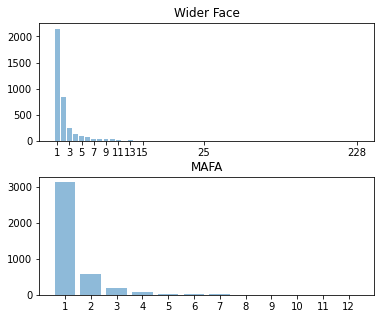

In [175]:
fig,ax=plt.subplots(2,1,figsize=(6,5))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

a = [len(df.labels[i]) for i in range(len(df)) if not df.filename[i].startswith("test")]
a = np.array(a)

u, counts = np.unique(a, return_counts=True)
ax[0].bar(range(len(u)), counts,alpha=0.5)
ax[0].set_xticks(np.arange(len(u))[np.r_[0:15:2, 24, len(u) - 1]])
ax[0].set_xticklabels(u[np.r_[0:15:2, 24, len(u) - 1]])
ax[0].set_title('Wider Face')


a = [len(df.labels[i]) for i in range(len(df)) if df.filename[i].startswith("test")]
a = np.array(a)
u, counts = np.unique(a, return_counts=True)
ax[1].bar(range(len(u)), counts,alpha=0.5)
ax[1].set_xticks(np.arange(len(u)))
ax[1].set_xticklabels(n)
ax[1].set_title('MAFA')
plt.savefig('report/num.png')
plt.show()


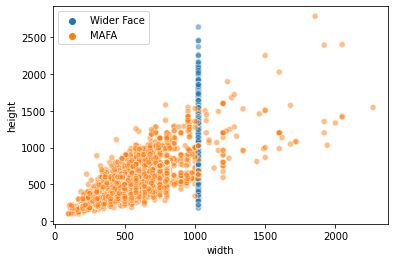

In [174]:
sb.scatterplot(df["width"], df["height"],[['Wider Face','MAFA'][i.startswith('test')] for i in df.filename],alpha=0.5)
plt.savefig('report/size.png')
plt.show()

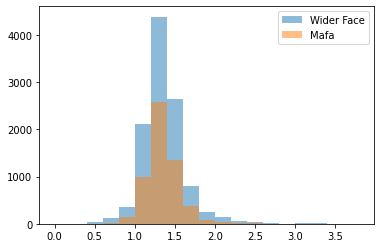

In [20]:
ratio=[(ymax-ymin)/(xmax-xmin) for xmins,ymins,xmaxs,ymaxs,h,w,filename in zip(df.xmins,df.ymins,df.xmaxs,df.ymaxs,df.height,df.width,df.filename) if not filename.startswith("test") for xmin,ymin,xmax,ymax in zip( xmins,ymins,xmaxs,ymaxs) ]
ratio1=[(ymax-ymin)/(xmax-xmin) for xmins,ymins,xmaxs,ymaxs,h,w,filename in zip(df.xmins,df.ymins,df.xmaxs,df.ymaxs,df.height,df.width,df.filename) if filename.startswith("test") for xmin,ymin,xmax,ymax in zip( xmins,ymins,xmaxs,ymaxs) ]
plt.hist(ratio,bins=np.arange(0,4,0.2),alpha=0.5)
plt.hist(ratio1,bins=np.arange(0,4,0.2),alpha=0.5)
plt.legend(['Wider Face','Mafa'])
plt.savefig('report/ratio.png')
plt.show()

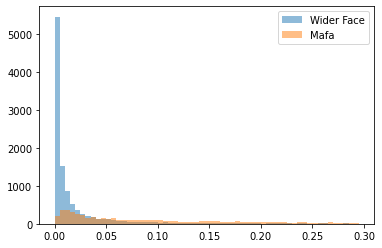

In [32]:
ratio=[(ymax-ymin)*(xmax-xmin)/h/w for xmins,ymins,xmaxs,ymaxs,h,w,filename in zip(df.xmins,df.ymins,df.xmaxs,df.ymaxs,df.height,df.width,df.filename) if not filename.startswith("test") for xmin,ymin,xmax,ymax in zip( xmins,ymins,xmaxs,ymaxs) ]
ratio1=[(ymax-ymin)*(xmax-xmin)/h/w for xmins,ymins,xmaxs,ymaxs,h,w,filename in zip(df.xmins,df.ymins,df.xmaxs,df.ymaxs,df.height,df.width,df.filename) if filename.startswith("test") for xmin,ymin,xmax,ymax in zip( xmins,ymins,xmaxs,ymaxs) ]
plt.hist(ratio,bins=np.arange(0,.3,0.005),alpha=0.5)
plt.hist(ratio1,bins=np.arange(0,.3,0.005),alpha=0.5)
plt.legend(['Wider Face','Mafa'])
plt.savefig('report/ratio2.png')
plt.show()

# FasterRCNN

## Data

In [6]:
dataset_train = dataset.AIZOODataset("train", dataset.transform_rcnn)
dataset_val = dataset.AIZOODataset("val", dataset.transform_rcnn)

In [7]:
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=True, num_workers=4, pin_memory=True, collate_fn=utils.collate_fn
)

In [8]:
data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=0, pin_memory=True, collate_fn=utils.collate_fn
)

## Model

In [9]:
model = models.faster_rcnn.get_model(pretrained="coco")
_ = model.to(device)

In [150]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [151]:
# checkpoint = torch.load("./data/checkpoint_160912")
# model.load_state_dict(checkpoint["model_state_dict"])
# _ = model.to(device)

## Train

In [152]:
import torch.backends.cudnn as cudnn
cudnn.benchmark = False

In [153]:
num_epochs = 1
losses = []
for epoch in range(num_epochs):
    losses += engine.train_one_epoch(model, optimizer, None, data_loader_train, device, epoch, print_freq=100)
    lr_scheduler.step()
    engine.evaluate(model, data_loader_val, device=device)

Epoch: [0]  [   0/3059]  eta: 1:06:43  lr: 0.000010  loss: 0.9573 (0.9573)  time: 1.3086  data: 0.6919  max mem: 0
Epoch: [0]  [ 100/3059]  eta: 0:07:12  lr: 0.000509  loss: 0.3021 (0.4878)  time: 0.1322  data: 0.0005  max mem: 0
Epoch: [0]  [ 200/3059]  eta: 0:06:36  lr: 0.001009  loss: 0.2291 (0.4125)  time: 0.1233  data: 0.0001  max mem: 0
Epoch: [0]  [ 300/3059]  eta: 0:06:18  lr: 0.001508  loss: 0.1760 (0.3610)  time: 0.1322  data: 0.0001  max mem: 0
Epoch: [0]  [ 400/3059]  eta: 0:05:59  lr: 0.002008  loss: 0.1495 (0.3268)  time: 0.1208  data: 0.0001  max mem: 0
Epoch: [0]  [ 500/3059]  eta: 0:05:43  lr: 0.002507  loss: 0.0817 (0.2983)  time: 0.1263  data: 0.0001  max mem: 0
Epoch: [0]  [ 600/3059]  eta: 0:05:26  lr: 0.003007  loss: 0.1482 (0.2888)  time: 0.1306  data: 0.0001  max mem: 0
Epoch: [0]  [ 700/3059]  eta: 0:05:11  lr: 0.003506  loss: 0.0971 (0.2748)  time: 0.1290  data: 0.0001  max mem: 0
Epoch: [0]  [ 800/3059]  eta: 0:04:58  lr: 0.004006  loss: 0.1714 (0.2631)  time

In [53]:
now = time.strftime("%m%d-%H%M")
torch.save(
    {"epoch": epoch, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(),},
    "./data/checkpoint_fr_" + now,
)
print(now)

0611-1348


In [154]:
losses = np.array(losses)
np.save("./data/losses_fr_" + time.strftime("%m%d-%H%M"), losses)

## Eval

In [159]:
losses0=np.load('./data/losses_fr_0611-0403.npy')
losses1=np.load('./data/losses_fr_0611-0303.npy')
losses2=np.load('./data/losses_fr_0611-0543.npy')

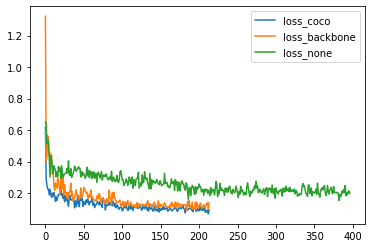

In [166]:
plt.plot([sum(losses0[i*100:i*100+100])/100 for i in range(len(losses0)//100)],alpha=1)
plt.plot([sum(losses1[i*100:i*100+100])/100 for i in range(len(losses1)//100)],alpha=1)
plt.plot([sum(losses2[i*100:i*100+100])/100 for i in range(len(losses2)//100)],alpha=1)
plt.legend(['loss_coco','loss_backbone','loss_none'])
plt.savefig('report/loss.png')

In [10]:
checkpoint = torch.load("./data/checkpoint_fr_0611-0403")
model.load_state_dict(checkpoint["model_state_dict"])
_ = model.to(device)

In [11]:
ap = engine.evaluate(model, data_loader_val, device=device)

In [12]:
ap.mean()

tensor(0.6157)

In [161]:
dataset_test = dataset.AIZOODataset("test", dataset.transform_rcnn)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, collate_fn=utils.collate_fn
)

In [165]:
ap = engine.evaluate(model, data_loader_test, device=device)
ap.mean()

0 100 200 300 400 500 600 700 800 900 fps: 24.30783290147557

AP@.5:  tensor([0.7506, 0.8332])
AP@.7:  tensor([0.5163, 0.6659])
AP@.9:  tensor([0.0909, 0.1078])
AP@[.5:.95]:  tensor([0.4226, 0.5137])


tensor(0.4681)

In [20]:
ap.mean()

tensor(0.6126)

In [121]:
det_boxes, det_labels, det_scores, true_boxes, true_labels = engine.evaluate(
    model, data_loader_test, device, return_eval=True
)

0 100 200 300 400 500 600 700 800 900 fps: 24.17352590218235


In [122]:
recall_thresholds = torch.arange(start=0, end=1.01, step=0.01).tolist()  # (11)
precisions15 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 1, 0.5)
precisions17 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 1, 0.7)
precisions19 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 1, 0.9)
precisions25 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 2, 0.5)
precisions27 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 2, 0.7)
precisions29 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 2, 0.9)

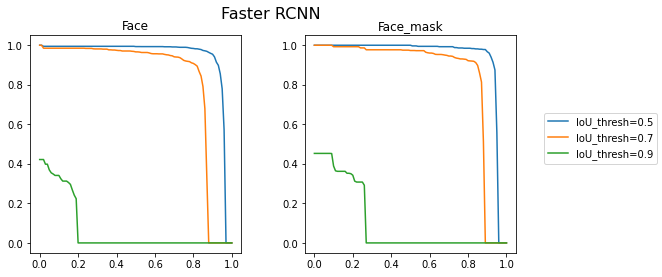

In [123]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
fig.subplots_adjust(hspace=0.3, wspace=0.3,right=0.8)
ax[0].plot(recall_thresholds,precisions15.tolist())
ax[0].plot(recall_thresholds,precisions17.tolist())
ax[0].plot(recall_thresholds,precisions19.tolist())
ax[0].set_title('Face')
ax[1].plot(recall_thresholds,precisions25.tolist())
ax[1].plot(recall_thresholds,precisions27.tolist())
ax[1].plot(recall_thresholds,precisions29.tolist())
fig.legend(['IoU_thresh=0.5','IoU_thresh=0.7','IoU_thresh=0.9'],loc='right')
ax[1].set_title('Face_mask')
fig.suptitle('Faster RCNN',fontsize=16,x=0.46)
plt.savefig('report/Faster_RCNN.png')

# SSD

## Data

In [223]:
dataset_train = dataset.AIZOODataset("train", dataset.transform_ssd_no_aug)
dataset_val = dataset.AIZOODataset("val", dataset.transform_ssd)

In [224]:
# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=8, shuffle=True, num_workers=4, pin_memory=True, collate_fn=utils.collate_fn
)

In [225]:
data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, collate_fn=utils.collate_fn
)

## Model

In [226]:
model = models.ssd.SSD300(n_classes=3)
model = model.to(device)

In [227]:
lr = 2e-3
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=5e-4)
criterion = models.ssd.MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [8, 11], gamma=0.1)

/home/zfr19/miniconda3/envs/py37/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


## Train

In [220]:
import torch.backends.cudnn as cudnn

cudnn.benchmark = True

In [221]:
num_epochs = 12
losses = []
for epoch in range(num_epochs):
    losses += engine.train_one_epoch(model, optimizer, criterion, data_loader_train, device, epoch, print_freq=100)
    lr_scheduler.step()
#     if epoch % 5 == 4:
#         engine.evaluate(model, data_loader_val, device=device)

Epoch: [0]  [  0/765]  eta: 0:18:34  lr: 0.000005  loss: 17.7844 (17.7844)  time: 1.4563  data: 1.0664  max mem: 0
Epoch: [0]  [100/765]  eta: 0:02:15  lr: 0.000266  loss: 5.8267 (9.2714)  time: 0.1782  data: 0.0010  max mem: 0
Epoch: [0]  [200/765]  eta: 0:01:50  lr: 0.000528  loss: 5.3802 (7.4603)  time: 0.1921  data: 0.0044  max mem: 0
Epoch: [0]  [300/765]  eta: 0:01:28  lr: 0.000789  loss: 4.5252 (6.6958)  time: 0.1839  data: 0.0018  max mem: 0
Epoch: [0]  [400/765]  eta: 0:01:09  lr: 0.001051  loss: 3.7489 (5.9975)  time: 0.1827  data: 0.0002  max mem: 0
Epoch: [0]  [500/765]  eta: 0:00:50  lr: 0.001312  loss: 3.5681 (5.5191)  time: 0.1817  data: 0.0002  max mem: 0
Epoch: [0]  [600/765]  eta: 0:00:31  lr: 0.001574  loss: 3.3543 (5.1694)  time: 0.1852  data: 0.0006  max mem: 0
Epoch: [0]  [700/765]  eta: 0:00:12  lr: 0.001835  loss: 3.5159 (4.8822)  time: 0.1840  data: 0.0016  max mem: 0
Epoch: [0]  [764/765]  eta: 0:00:00  lr: 0.002000  loss: 2.8380 (4.7423)  time: 0.1763  data: 

In [181]:
now = time.strftime("%m%d-%H%M")
torch.save(
    {"epoch": epoch, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(),},
    "./data/checkpoint_ssd_no_aug" + now,
)
print(now)

RuntimeError: write(): fd 97 failed with No space left on device

In [222]:
losses = np.array(losses)
np.save("./data/losses_ssd" + time.strftime("%m%d-%H%M"), losses)

In [24]:
num_epochs = 12

for epoch in range(num_epochs):
    engine.train_one_epoch(model, optimizer, criterion, data_loader_train, device, epoch, print_freq=100)
    lr_scheduler.step()
    if epoch % 5 == 4:
        engine.evaluate(model, data_loader_val, device=device)

Epoch: [0]  [  0/765]  eta: 0:17:47  lr: 0.000006  loss: 17.7647 (17.7647)  time: 1.3960  data: 1.1844  max mem: 0
Epoch: [0]  [100/765]  eta: 0:02:12  lr: 0.000406  loss: 5.6828 (8.6593)  time: 0.1871  data: 0.0026  max mem: 0
Epoch: [0]  [200/765]  eta: 0:01:48  lr: 0.000805  loss: 5.1789 (7.0683)  time: 0.1884  data: 0.0006  max mem: 0
Epoch: [0]  [300/765]  eta: 0:01:28  lr: 0.001205  loss: 3.8562 (6.2523)  time: 0.1911  data: 0.0007  max mem: 0
Epoch: [0]  [400/765]  eta: 0:01:09  lr: 0.001604  loss: 3.4744 (5.6377)  time: 0.2007  data: 0.0139  max mem: 0
Epoch: [0]  [500/765]  eta: 0:00:50  lr: 0.002000  loss: 3.5652 (5.2630)  time: 0.1906  data: 0.0011  max mem: 0
Epoch: [0]  [600/765]  eta: 0:00:31  lr: 0.002000  loss: 3.0134 (4.9322)  time: 0.1918  data: 0.0006  max mem: 0
Epoch: [0]  [700/765]  eta: 0:00:12  lr: 0.002000  loss: 2.7622 (4.6772)  time: 0.1879  data: 0.0016  max mem: 0
Epoch: [0]  [764/765]  eta: 0:00:00  lr: 0.002000  loss: 2.7405 (4.5403)  time: 0.1794  data: 

## Eval

In [188]:
checkpoint = torch.load("./data/checkpoint_ssd0604-1441")
model.load_state_dict(checkpoint["model_state_dict"])
_ = model.to(device)

In [230]:
ap = engine.evaluate(model, data_loader_val, device)

0 100 200 300 400 500 600 700 800 fps: 60.83379969995753

AP@.5:  tensor([0.8004, 0.8984])
AP@.7:  tensor([0.6042, 0.7784])
AP@.9:  tensor([0.0559, 0.1143])
AP@[.5:.95]:  tensor([0.4767, 0.5898])


In [231]:
ap.mean()

tensor(0.5333)

In [201]:
dataset_test = dataset.AIZOODataset("test", dataset.transform_ssd)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, collate_fn=utils.collate_fn
)

In [202]:
ap = engine.evaluate(model, data_loader_test, device)

0 100 200 300 400 500 600 700 800 900 fps: 58.68426540949848

AP@.5:  tensor([0.7974, 0.8997])
AP@.7:  tensor([0.6641, 0.7688])
AP@.9:  tensor([0.1165, 0.1202])
AP@[.5:.95]:  tensor([0.5015, 0.5876])


In [205]:
ap.mean()

tensor(0.5445)

In [115]:
det_boxes, det_labels, det_scores, true_boxes, true_labels = engine.evaluate(
    model, data_loader_test, device, return_eval=True
)

0 100 200 300 400 500 600 700 800 900 fps: 60.848435256045626


In [116]:
recall_thresholds = torch.arange(start=0, end=1.01, step=0.01).tolist()  # (11)
precisions15 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 1, 0.5)
precisions17 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 1, 0.7)
precisions19 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 1, 0.9)
precisions25 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 2, 0.5)
precisions27 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 2, 0.7)
precisions29 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 2, 0.9)

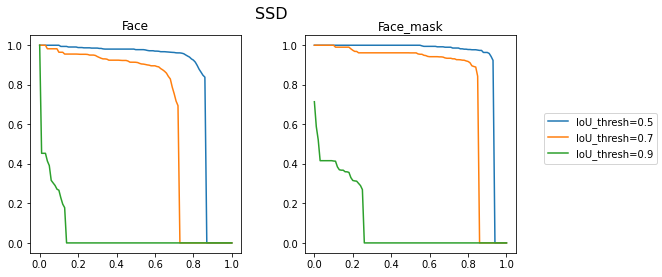

In [117]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
fig.subplots_adjust(hspace=0.3, wspace=0.3,right=0.8)
ax[0].plot(recall_thresholds,precisions15.tolist())
ax[0].plot(recall_thresholds,precisions17.tolist())
ax[0].plot(recall_thresholds,precisions19.tolist())
ax[0].set_title('Face')
ax[1].plot(recall_thresholds,precisions25.tolist())
ax[1].plot(recall_thresholds,precisions27.tolist())
ax[1].plot(recall_thresholds,precisions29.tolist())
fig.legend(['IoU_thresh=0.5','IoU_thresh=0.7','IoU_thresh=0.9'],loc='right')
ax[1].set_title('Face_mask')
fig.suptitle('SSD',fontsize=16,x=0.46)
plt.savefig('report/SSD.png')

In [232]:
losses0=np.load('./data/losses_ssd0611-1803.npy')
losses1=np.load('./data/losses_ssd0611-1832.npy')

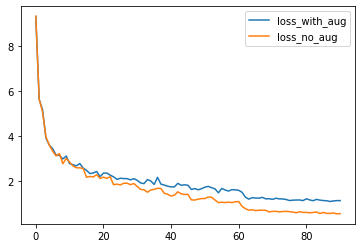

In [234]:
plt.plot([sum(losses0[i*100:i*100+100])/100 for i in range(len(losses0)//100)],alpha=1)
plt.plot([sum(losses1[i*100:i*100+100])/100 for i in range(len(losses1)//100)],alpha=1)
plt.legend(['loss_with_aug','loss_no_aug'])
plt.savefig('report/loss.png')

# RetinaNet

In [7]:
reload(utils)
reload(dataset)
reload(dataset)
reload(metric)
reload(engine)

<module 'engine' from '/home/zfr19/Documents/project0/engine.py'>

## data

In [21]:
dataset_train = dataset.AIZOODataset("train", dataset.transform_retina,plus=-1)
dataset_val = dataset.AIZOODataset("val", dataset.transform_retina,plus=-1)

In [22]:
# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=True, num_workers=4, pin_memory=True, collate_fn=utils.collate_fn
)

In [23]:
data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, collate_fn=utils.collate_fn
)

## model

In [24]:
import models.retinanet
reload(models.retinanet)

<module 'models.retinanet' from '/home/zfr19/Documents/project0/models/retinanet.py'>

In [106]:
model=models.retinanet.resnet50(num_classes=2,pretrained=True)
_ = model.to(device)

In [37]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

## train

In [ ]:
num_epochs = 7
losses = []
for epoch in range(num_epochs):
    model.freeze_bn()
    losses += engine.train_one_epoch(model, optimizer, None, data_loader_train, device, epoch, print_freq=100)
    lr_scheduler.step()
    engine.evaluate(model, data_loader_val, device=device)

Epoch: [0]  [   0/3059]  eta: 0:48:12  lr: 0.000000  loss_cls: 1.1308 (1.1308)  loss_reg: 1.1019 (1.1019)  loss: 2.2327 (2.2327)  time: 0.9457  data: 0.5417  max mem: 0
Epoch: [0]  [ 100/3059]  eta: 0:10:29  lr: 0.000010  loss_cls: 0.5621 (0.8595)  loss_reg: 0.9563 (1.0015)  loss: 1.5055 (1.8610)  time: 0.2137  data: 0.0005  max mem: 0
Epoch: [0]  [ 200/3059]  eta: 0:09:41  lr: 0.000020  loss_cls: 0.4818 (0.6926)  loss_reg: 0.8211 (0.9354)  loss: 1.2983 (1.6279)  time: 0.1980  data: 0.0001  max mem: 0
Epoch: [0]  [ 300/3059]  eta: 0:09:21  lr: 0.000030  loss_cls: 0.4770 (0.6398)  loss_reg: 0.7684 (0.8819)  loss: 1.2702 (1.5217)  time: 0.1955  data: 0.0001  max mem: 0
Epoch: [0]  [ 400/3059]  eta: 0:08:58  lr: 0.000040  loss_cls: 0.3812 (0.5939)  loss_reg: 0.7469 (0.8404)  loss: 1.1803 (1.4343)  time: 0.2105  data: 0.0001  max mem: 0
Epoch: [0]  [ 500/3059]  eta: 0:08:38  lr: 0.000050  loss_cls: 0.3223 (0.5466)  loss_reg: 0.6780 (0.8010)  loss: 1.0008 (1.3477)  time: 0.2106  data: 0.000

In [22]:
num_epochs = 7
losses = []
for epoch in range(num_epochs):
    model.freeze_bn()
    losses += engine.train_one_epoch(model, optimizer, None, data_loader_train, device, epoch, print_freq=100)
    lr_scheduler.step()
    engine.evaluate(model, data_loader_val, device=device)

Epoch: [0]  [   0/3059]  eta: 0:45:27  lr: 0.000000  loss_cls: 1.1299 (1.1299)  loss_reg: 1.1184 (1.1184)  loss: 2.2483 (2.2483)  time: 0.8916  data: 0.4487  max mem: 0
Epoch: [0]  [ 100/3059]  eta: 0:10:18  lr: 0.000010  loss_cls: 0.5512 (0.8531)  loss_reg: 0.9516 (0.9823)  loss: 1.5618 (1.8354)  time: 0.1887  data: 0.0001  max mem: 0
Epoch: [0]  [ 200/3059]  eta: 0:09:49  lr: 0.000020  loss_cls: 0.4869 (0.7111)  loss_reg: 0.8144 (0.9220)  loss: 1.3305 (1.6331)  time: 0.2079  data: 0.0001  max mem: 0
Epoch: [0]  [ 300/3059]  eta: 0:09:28  lr: 0.000030  loss_cls: 0.4663 (0.6235)  loss_reg: 0.7207 (0.8594)  loss: 1.1358 (1.4830)  time: 0.2066  data: 0.0001  max mem: 0
Epoch: [0]  [ 400/3059]  eta: 0:09:05  lr: 0.000040  loss_cls: 0.2808 (0.5735)  loss_reg: 0.7209 (0.8240)  loss: 1.0428 (1.3975)  time: 0.2011  data: 0.0001  max mem: 0
Epoch: [0]  [ 500/3059]  eta: 0:08:45  lr: 0.000050  loss_cls: 0.2816 (0.5269)  loss_reg: 0.6414 (0.7957)  loss: 0.8952 (1.3226)  time: 0.2068  data: 0.000

In [23]:
now = time.strftime("%m%d-%H%M")
torch.save(
    {"epoch": epoch, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(),},
    "./data/checkpoint_retina_" + now,
)
print(now)

0609-1913


## eval

In [107]:
checkpoint = torch.load("./data/checkpoint_retina_0609-1913")
model.load_state_dict(checkpoint["model_state_dict"])
_ = model.to(device)

In [108]:
dataset_test = dataset.AIZOODataset("test", dataset.transform_retina,plus=-1)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, collate_fn=utils.collate_fn
)

In [29]:
ap = engine.evaluate(model, data_loader_test, device)

0 100 200 300 400 500 600 700 800 900 fps: 26.373309408845692

AP@.5:  tensor([0.8092, 0.9013])
AP@.7:  tensor([0.7927, 0.7888])
AP@.9:  tensor([0.1350, 0.1309])
AP@[.5:.95]:  tensor([0.5789, 0.6179])


In [32]:
ap.mean(1)[[0,4,8]]

tensor([0.8552, 0.7908, 0.1329])

In [109]:
det_boxes, det_labels, det_scores, true_boxes, true_labels = engine.evaluate(
    model, data_loader_test, device, return_eval=True
)

0 100 200 300 400 500 600 700 800 900 fps: 28.1164862709855


In [110]:
recall_thresholds = torch.arange(start=0, end=1.01, step=0.01).tolist()  # (11)
precisions15 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 1, 0.5)
precisions17 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 1, 0.7)
precisions19 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 1, 0.9)
precisions25 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 2, 0.5)
precisions27 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 2, 0.7)
precisions29 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 2, 0.9)

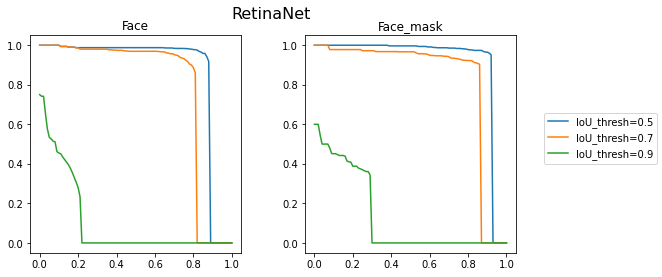

In [111]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
fig.subplots_adjust(hspace=0.3, wspace=0.3,right=0.8)
ax[0].plot(recall_thresholds,precisions15.tolist())
ax[0].plot(recall_thresholds,precisions17.tolist())
ax[0].plot(recall_thresholds,precisions19.tolist())
ax[0].set_title('Face')
ax[1].plot(recall_thresholds,precisions25.tolist())
ax[1].plot(recall_thresholds,precisions27.tolist())
ax[1].plot(recall_thresholds,precisions29.tolist())
fig.legend(['IoU_thresh=0.5','IoU_thresh=0.7','IoU_thresh=0.9'],loc='right')
ax[1].set_title('Face_mask')
fig.suptitle('RetinaNet',fontsize=16,x=0.46)
plt.savefig('report/RetinaNet.png')

# FAN

In [49]:
reload(utils)
reload(dataset)
reload(dataset)
reload(metric)
reload(engine)

<module 'engine' from '/home/zfr19/Documents/project0/engine.py'>

## data

In [6]:
dataset_train = dataset.AIZOODataset("train", dataset.transform_retina,plus=-1)
dataset_val = dataset.AIZOODataset("val", dataset.transform_retina,plus=-1)

In [7]:
# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=True, num_workers=4, pin_memory=True, collate_fn=utils.collate_fn
)

In [8]:
data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, collate_fn=utils.collate_fn
)

## model

In [35]:
import models.fan
reload(models.fan)

<module 'models.fan' from '/home/zfr19/Documents/project0/models/fan.py'>

In [36]:
model=models.fan.resnet50(num_classes=2,pretrained=True)
_ = model.to(device)

In [11]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

## train

In [14]:
a=1

In [15]:
a

1

In [ ]:
num_epochs = 7
losses = []
for epoch in range(num_epochs):
    model.freeze_bn()
    losses += engine.train_one_epoch(model, optimizer, None, data_loader_train, device, epoch, print_freq=100)
    lr_scheduler.step()
    engine.evaluate(model, data_loader_val, device=device)

Epoch: [0]  [   0/3059]  eta: 2:52:01  lr: 0.000000  loss_cls: 1.1301 (1.1301)  loss_reg: 1.0748 (1.0748)  loss_att: 0.6931 (0.6931)  loss: 2.8981 (2.8981)  time: 3.3743  data: 2.6516  max mem: 0
Epoch: [0]  [ 100/3059]  eta: 0:12:19  lr: 0.000010  loss_cls: 0.5458 (0.8455)  loss_reg: 0.9726 (0.9731)  loss_att: 0.2800 (0.4896)  loss: 1.8065 (2.3082)  time: 0.2219  data: 0.0001  max mem: 0
Epoch: [0]  [ 200/3059]  eta: 0:11:10  lr: 0.000020  loss_cls: 0.4885 (0.6907)  loss_reg: 0.8203 (0.9214)  loss_att: 0.2153 (0.3727)  loss: 1.6003 (1.9849)  time: 0.2189  data: 0.0001  max mem: 0
Epoch: [0]  [ 300/3059]  eta: 0:10:29  lr: 0.000030  loss_cls: 0.3855 (0.6143)  loss_reg: 0.6972 (0.8789)  loss_att: 0.1697 (0.3099)  loss: 1.3204 (1.8031)  time: 0.2130  data: 0.0001  max mem: 0
Epoch: [0]  [ 400/3059]  eta: 0:10:01  lr: 0.000040  loss_cls: 0.3221 (0.5713)  loss_reg: 0.7503 (0.8372)  loss_att: 0.0972 (0.2783)  loss: 1.2288 (1.6868)  time: 0.2225  data: 0.0001  max mem: 0
Epoch: [0]  [ 500/30

In [ ]:
now = time.strftime("%m%d-%H%M")
torch.save(
    {"epoch": epoch, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(),},
    "./data/checkpoint_fan_" + now,
)
print(now)

## eval

In [37]:
checkpoint = torch.load("./data/checkpoint_fan_0609-1715")
model.load_state_dict(checkpoint["model_state_dict"])
_ = model.to(device)

In [28]:
dataset_test = dataset.AIZOODataset("test", dataset.transform_retina,plus=-1)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, collate_fn=utils.collate_fn
)

In [38]:
ap = engine.evaluate(model, data_loader_test, device)

0 100 200 300 400 500 600 700 800 900 fps: 24.621237002687206

AP@.5:  tensor([0.8792, 0.9008])
AP@.7:  tensor([0.7787, 0.7822])
AP@.9:  tensor([0.0940, 0.1619])
AP@[.5:.95]:  tensor([0.5860, 0.6166])


In [43]:
ap.mean()

tensor(0.6013)

In [44]:
det_boxes, det_labels, det_scores, true_boxes, true_labels = engine.evaluate(
    model, data_loader_test, device, return_eval=True
)

0 100 200 300 400 500 600 700 800 900 fps: 24.146181880787566


In [51]:
recall_thresholds = torch.arange(start=0, end=1.01, step=0.01).tolist()  # (11)
precisions15 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 1, 0.5)
precisions17 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 1, 0.7)
precisions19 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 1, 0.9)
precisions25 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 2, 0.5)
precisions27 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 2, 0.7)
precisions29 = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, 2, 0.9)

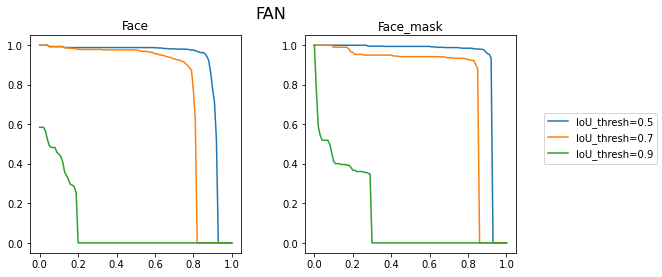

In [105]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
fig.subplots_adjust(hspace=0.3, wspace=0.3,right=0.8)
ax[0].plot(recall_thresholds,precisions15.tolist())
ax[0].plot(recall_thresholds,precisions17.tolist())
ax[0].plot(recall_thresholds,precisions19.tolist())
ax[0].set_title('Face')
ax[1].plot(recall_thresholds,precisions25.tolist())
ax[1].plot(recall_thresholds,precisions27.tolist())
ax[1].plot(recall_thresholds,precisions29.tolist())
fig.legend(['IoU_thresh=0.5','IoU_thresh=0.7','IoU_thresh=0.9'],loc='right')
ax[1].set_title('Face_mask')
fig.suptitle('FAN',fontsize=16,x=0.46)
plt.savefig('report/FAN.png')

# PR curve

In [125]:
recall_thresholds = torch.arange(start=0, end=1.01, step=0.01).tolist()  # (11)

In [135]:
precisions = metric.calcuate_PR(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, 1, 0.9)

In [136]:
precisions = precisions.tolist()

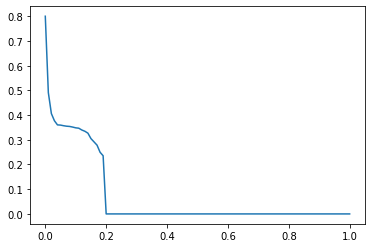

In [137]:
plt.plot(recall_thresholds, precisions)

# Detect

In [346]:
from PIL import ImageDraw

bases = ["./data/AIZOO/train/", "./data/AIZOO/val/"]

In [347]:
df = pd.read_pickle("./data/AIZOO.pkl")
df = df[df.is_train == False]
df.index = list(range(len(df)))

In [334]:
checkpoint = torch.load("./data/checkpoint_160912")
model.load_state_dict(checkpoint["model_state_dict"])
_ = model.to(device)

In [373]:
# img = Image.open("./data/IMG_20200602_201501.jpg").convert("RGB")
idx=799
file = (bases[0] if df.is_train[idx] else bases[1]) + df.filename[idx] + '.jpg'
img = Image.open(file).convert('RGB')

In [374]:
# tran = get_transform(False)
img_arr, _ ,_= dataset.transform_rcnn(img, None,None,'val')
with torch.no_grad():
    prediction = model([img_arr.to(device)])[0]

In [375]:
prediction

{'boxes': tensor([[497.3228, 208.5763, 615.2675, 388.4888]], device='cuda:1'),
 'labels': tensor([2], device='cuda:1'),
 'scores': tensor([0.9909], device='cuda:1')}

In [ ]:
file = (bases[0] if df.is_train[idx] else bases[1]) + df.filename[idx] + '.jpg'
img = Image.open(file).convert('RGB')
draw = ImageDraw.Draw(img, "RGBA")
for i in range(len(prediction["labels"])):
    if prediction["scores"][i] > 0.5:
        xmin, ymin, xmax, ymax = prediction["boxes"][i]
        label = prediction["labels"][i]
        color = "yellow" if label == 1 else "red"
        draw.rectangle(((xmin, ymin), (xmax, ymax)), fill="#00000000", outline=color)
display(img)

In [377]:
img.size

(1200, 800)

In [ ]:
file = (bases[0] if df.is_train[idx] else bases[1]) + df.filename[idx] + ".jpg"
img = Image.open(file).convert("RGB")
draw = ImageDraw.Draw(img, "RGBA")
for label, xmin, ymin, xmax, ymax in zip(df.labels[idx], df.xmins[idx], df.ymins[idx], df.xmaxs[idx], df.ymaxs[idx]):
    color = "yellow" if label == 1 else "red"
    draw.rectangle(((xmin, ymin), (xmax, ymax)), fill="#00000000", outline=color)
display(img)